In [1]:
import math
import random
import pickle
import datetime
import community
import numpy as np
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from collections import defaultdict
from scipy.interpolate import griddata
from networkx.algorithms.community import LFR_benchmark_graph

In [3]:
Data_Root = '/data/haopeng/Diffusion/LFR/'
net_name = 'LFR'

In [4]:
num_nodes = 25000
avg_degree = 10
thsh = 0.3
num_runs = 500
f = 0.01

In [5]:
tau1 = 2.5
tau2 = 1.5
max_degree = 30

In [6]:
rhos = np.arange(0, 0.51, 0.01)
us = np.arange(0.1, 1.00, 0.02)

First run the script in the folder `lfr_hpc` on hpc:
- run this command: `sbatch lfr_hpc.slurm`

In [7]:
results = defaultdict()

In [ ]:
# for i in range(51):
#     rho = rhos[i]
#     with open(Data_Root+'per_step_data/phase_simu_nodes_%sk_z_%s_thsh_%s_f_%s_%s.pickle'%(num_nodes//1000, avg_degree, thsh, f, i), 'rb') as file:
#         tem = pickle.load(file)
#         results[rho] = tem

In [ ]:
# with open(Data_Root+'per_step_data/phase_simu_nodes_%sk_z_%s_thsh_%s_f_%s.pickle'%(num_nodes//1000, avg_degree, thsh, f), 'wb') as file:
#     pickle.dump(dict(results), file)

In [8]:
with open(Data_Root+'per_step_data/phase_simu_nodes_%sk_z_%s_thsh_%s_f_%s.pickle'%(num_nodes//1000, avg_degree, thsh, f), 'rb') as file:
    results = pickle.load(file)

In [9]:
sweeping_results = defaultdict(dict)

for rho in rhos:
    num_seeds = int(rho*num_nodes)
    for u in us:
        tem_results = []
        for size, step, activation_per_step in results[rho][u]:
            tem_results.append((size, step))
        sizes = [size/num_nodes for (size, step) in tem_results]
        rates = [(size-num_seeds)/(step*num_nodes) if step > 0 else 0 for (size, step) in tem_results]
        sweeping_results[rho][u] = (sizes, rates)

In [10]:
del results

### Calculate normalized modularity

In [89]:
def attribute_assortativity_coefficient(G, partition, directed=False):
    num_community = len(set(partition.values()))
    mixing_matrix = np.zeros(shape = (num_community, num_community))              
    for s, t in G.edges():
        mixing_matrix[partition[s], partition[t]] += 1
        # if undirect, the order (s, t) gives by G.edges() is misleading. So we double count every edge.
        if not directed:
            mixing_matrix[partition[t], partition[s]] += 1
    mixing_matrix /= np.sum(mixing_matrix)
    square_sum = np.sum(np.linalg.matrix_power(mixing_matrix, 2))
    tra = np.trace(mixing_matrix)
    r = (tra - square_sum)/(1-square_sum)
    return r

In [118]:
u_to_Q = {}

for u in us:
    G = LFR_benchmark_graph(num_nodes, tau1, tau2, u, average_degree=avg_degree, max_degree=max_degree, seed=10)
    communities = {frozenset(G.nodes[v]['community']) for v in G}
    part = {}
    for i, C in enumerate(communities):
        for node in C:
            part[node] = i
    Q_norm = attribute_assortativity_coefficient(G, part)
    u_to_Q[u] = Q_norm

### Phase diagram

In [11]:
class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.0f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_orderOfMagnitude(self, nothing):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin, vmax):
        self.format = self.fformat
        if self._useMathText:
            self.format = '$%s$' % matplotlib.ticker._mathdefault(self.format)

In [12]:
# x_range = np.arange(0.1, 0.51, 0.001)
x_range = np.arange(0, 1.01, 0.001)
y_range = np.arange(0, 0.51, 0.001)
X, Y = np.meshgrid(x_range, y_range)

In [13]:
points = []
values_size = []
values_rate = []
lower_boundary = []
upper_boundary = []
max_rate = []
            
for rho in rhos:
    lower_u, upper_u = 0, 0
    for u in us:
        points.append([u, rho])
        avg_size = np.mean(sweeping_results[rho][u][0])
        values_size.append(avg_size)
        avg_rate = np.mean(sweeping_results[rho][u][1])
        values_rate.append(avg_rate)
        
        if avg_size >= 0.99:
            if lower_u == 0:
                lower_u = u
            upper_u = u
    if lower_u < upper_u:
        lower_boundary.append([lower_u, rho])
        upper_boundary.append([upper_u, rho])
        optimal_u = 0
        min_rate = np.mean(sweeping_results[rho][lower_u][1])
        for u in us:
            if u >= lower_u and u <= upper_u:
                avg_rate = np.mean(sweeping_results[rho][u][1])
                if avg_rate >= min_rate:
                    optimal_u = u
                    min_rate = avg_rate
        max_rate.append([optimal_u, rho])

lower_boundary = np.array(lower_boundary)
upper_boundary = np.array(upper_boundary)
max_rate = np.array(max_rate)

Z_size = griddata(points, values_size, (X, Y), method = 'cubic')
Z_rate = griddata(points, values_rate, (X, Y), method = 'cubic')

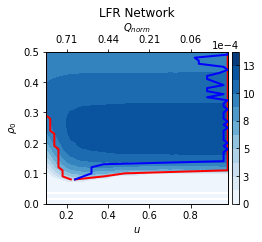

In [13]:
fig, ax = plt.subplots(figsize = (3.5, 2.8))
levels = np.linspace(0.0, 14e-4, 12)
ct = ax.contourf(X, Y, Z_rate, cmap = 'Blues', levels=levels)
cb = fig.colorbar(ct, ax=ax, fraction=0.05, pad=0.02, format=OOMFormatter(-4, mathText=False))
cb.ax.tick_params(axis='y', direction='in')

ax.plot(lower_boundary[:, 0], lower_boundary[:, 1], linewidth = 2, color='r')
ax.plot(upper_boundary[:, 0], upper_boundary[:, 1], linewidth = 2, color='r')
ax.plot(max_rate[:, 0], max_rate[:, 1], linewidth = 2, color='b')
# ax.axhline(y=0.10, linewidth=1, linestyle='--', color='k')
ax.set_xlabel(r'$u$')
ax.set_ylabel(r'$\rho_0$')
ax.set_xlim(0.1, 0.98)
ax.set_ylim(0, 0.5)
ax.set_title('LFR Network', pad=35)

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
xticks = [0.2, 0.4, 0.6000000000000001, 0.8000000000000002]
ax2.set_xticks(xticks)
ax2.set_xticklabels(["%.2f"%u_to_Q[u] for u in xticks])
ax2.set_xlabel(r"$Q_{norm}$")

plt.show()
fig.savefig('LFR_phase.pdf', bbox_inches='tight', pad_inches=0.02)